<a href="https://colab.research.google.com/github/Muhammad-Lutfi-2002/Data_analytics/blob/main/Rfm_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go

In [6]:
# STEP 1: Collect and Preprocess Data

# Load data
df = pd.read_csv('rfm_data.csv')
df['PurchaseDate'] = pd.to_datetime(df['PurchaseDate'])

In [7]:
# Data quality analysis
print("\nData Quality Check:")
print("1. Missing Values:")
print(df.isnull().sum())
print("\n2. Data Types:")
print(df.dtypes)
print("\n3. Basic Statistics:")
print(df.describe())


Data Quality Check:
1. Missing Values:
CustomerID            0
PurchaseDate          0
TransactionAmount     0
ProductInformation    0
OrderID               0
Location              0
dtype: int64

2. Data Types:
CustomerID                     int64
PurchaseDate          datetime64[ns]
TransactionAmount            float64
ProductInformation            object
OrderID                        int64
Location                      object
dtype: object

3. Basic Statistics:
        CustomerID                PurchaseDate  TransactionAmount  \
count  1000.000000                        1000         1000.00000   
mean   5554.789000  2023-05-10 07:27:50.400000          513.67781   
min    1011.000000         2023-04-11 00:00:00           12.13000   
25%    3273.000000         2023-04-26 00:00:00          257.12000   
50%    5538.000000         2023-05-09 00:00:00          523.56500   
75%    7821.750000         2023-05-26 00:00:00          759.86000   
max    9991.000000         2023-06-10 00:00:00

In [8]:
# Transaction patterns
print("\nTransaction Patterns:")
print("Total Customers:", df['CustomerID'].nunique())
print("Total Transactions:", len(df))
print("Date Range:", df['PurchaseDate'].min(), "to", df['PurchaseDate'].max())


Transaction Patterns:
Total Customers: 946
Total Transactions: 1000
Date Range: 2023-04-11 00:00:00 to 2023-06-10 00:00:00


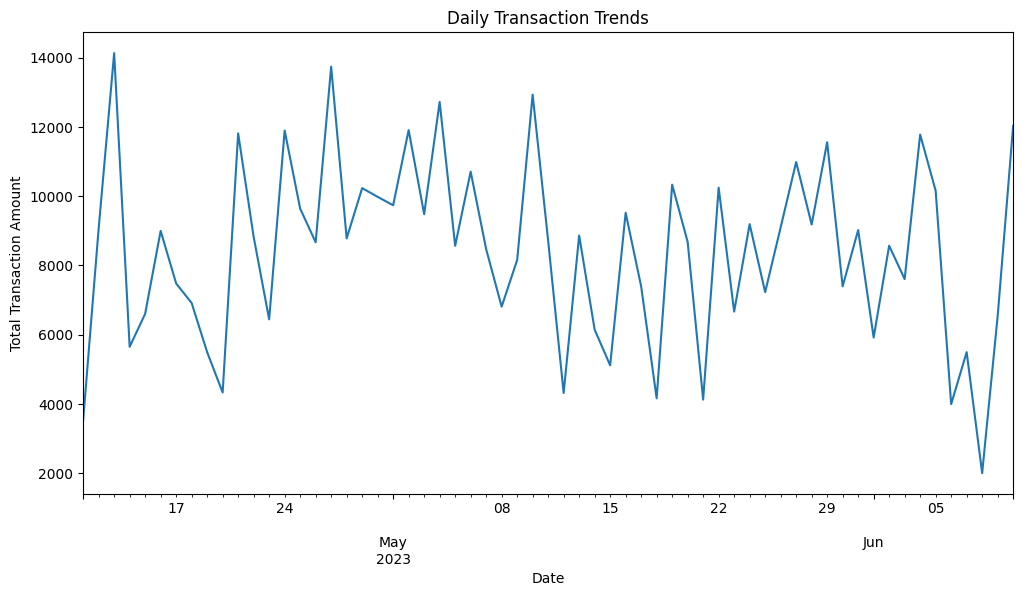

In [9]:
# Visualize transaction trends
plt.figure(figsize=(12, 6))
df.groupby('PurchaseDate')['TransactionAmount'].sum().plot()
plt.title('Daily Transaction Trends')
plt.xlabel('Date')
plt.ylabel('Total Transaction Amount')
plt.show()

In [10]:
# STEP 2: Calculate RFM Metrics
reference_date = df['PurchaseDate'].max()

rfm = df.groupby('CustomerID').agg({
    'PurchaseDate': lambda x: (reference_date - x.max()).days,
    'OrderID': 'count',
    'TransactionAmount': ['sum', 'mean']
}).reset_index()

rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary_Sum', 'Monetary_Avg']

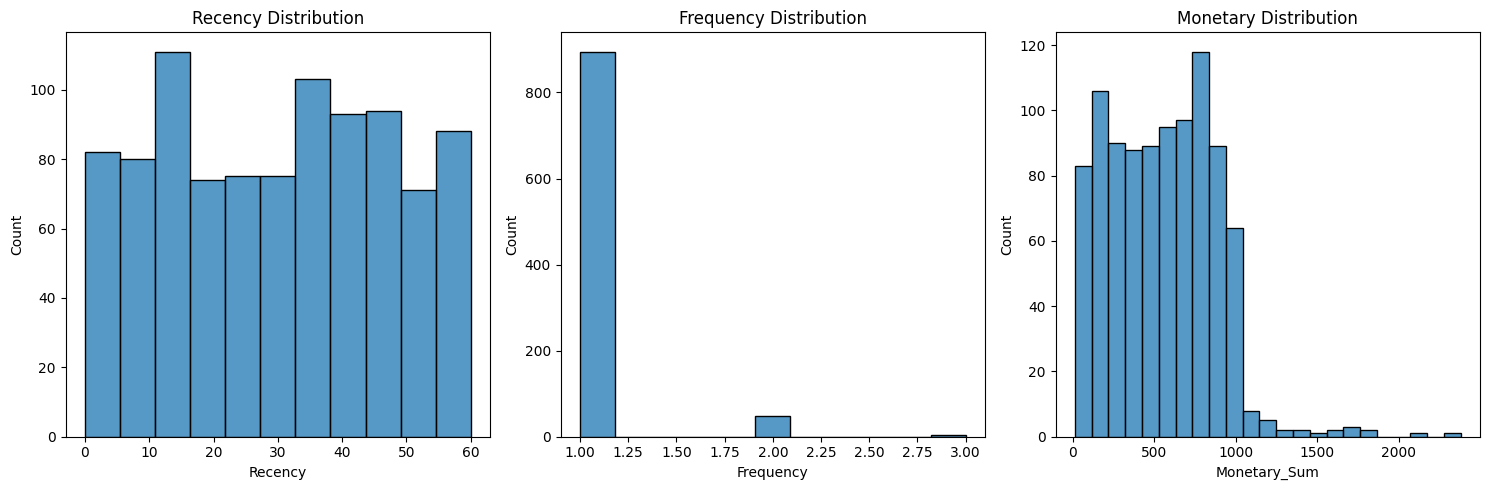

In [11]:
# RFM Metrics Distribution
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=rfm, x='Recency', ax=axes[0])
sns.histplot(data=rfm, x='Frequency', ax=axes[1])
sns.histplot(data=rfm, x='Monetary_Sum', ax=axes[2])
axes[0].set_title('Recency Distribution')
axes[1].set_title('Frequency Distribution')
axes[2].set_title('Monetary Distribution')
plt.tight_layout()
plt.show()

In [15]:
# STEP 3: Customer Segmentation

# Calculate RFM quartiles
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)

r_quartiles = pd.qcut(rfm['Recency'], q=4, labels=r_labels)
f_quartiles = pd.cut(rfm['Frequency'], bins=4, labels=f_labels)
m_quartiles = pd.qcut(rfm['Monetary_Sum'], q=4, labels=m_labels)

rfm['R'] = r_quartiles
rfm['F'] = f_quartiles
rfm['M'] = m_quartiles
rfm['RFM_Score'] = rfm['R'].astype(str) + rfm['F'].astype(str) + rfm['M'].astype(str)

In [16]:
# Define detailed segments
def get_segment(row):
    if row['R'] >= 3 and row['F'] >= 3 and row['M'] >= 3:
        return 'Champions'
    elif row['R'] >= 3 and row['F'] >= 2 and row['M'] >= 2:
        return 'Loyal Customers'
    elif row['R'] >= 3 and row['F'] <= 2 and row['M'] <= 2:
        return 'Recent Customers'
    elif row['R'] <= 2 and row['F'] >= 3 and row['M'] >= 3:
        return 'At Risk'
    elif row['R'] <= 2 and row['F'] <= 2 and row['M'] >= 3:
        return 'Lost Big Spenders'
    elif row['R'] <= 2 and row['F'] <= 2 and row['M'] <= 2:
        return 'Lost Customers'
    else:
        return 'Average Customers'

rfm['Customer_Segment'] = rfm.apply(get_segment, axis=1)

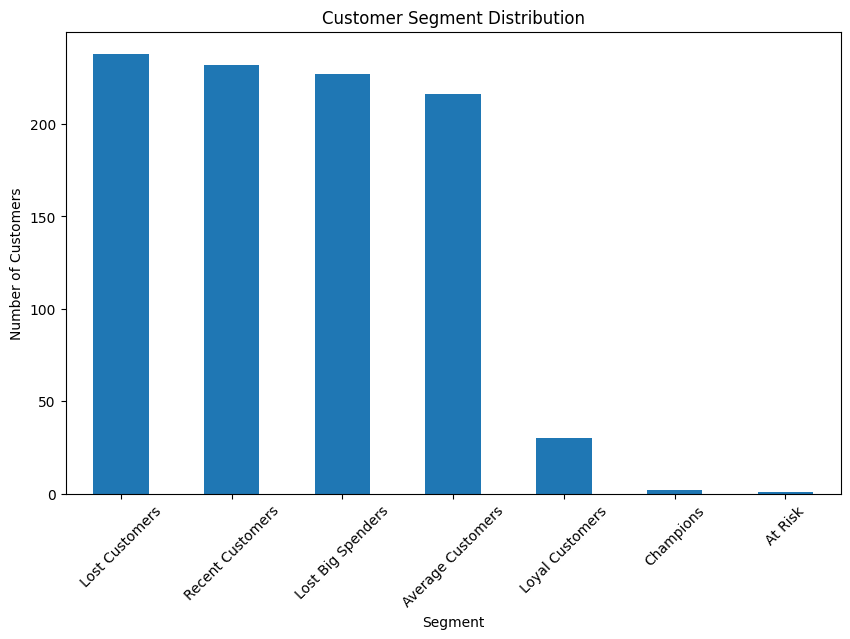

In [17]:
# STEP 4: Segment Analysis
# Segment distribution
segment_dist = rfm['Customer_Segment'].value_counts()
plt.figure(figsize=(10, 6))
segment_dist.plot(kind='bar')
plt.title('Customer Segment Distribution')
plt.xlabel('Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

In [18]:
# Segment characteristics
segment_analysis = rfm.groupby('Customer_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary_Sum': 'mean',
    'CustomerID': 'count'
}).round(2)

print("\nSegment Characteristics:")
print(segment_analysis)


Segment Characteristics:
                   Recency  Frequency  Monetary_Sum  CustomerID
Customer_Segment                                               
At Risk              38.00       3.00       1386.32           1
Average Customers    15.94       1.00        777.78         216
Champions            17.50       3.00       2226.39           2
Lost Big Spenders    44.96       1.06        786.97         227
Lost Customers       45.56       1.01        275.06         238
Loyal Customers      14.20       2.00       1067.04          30
Recent Customers     14.54       1.01        274.66         232


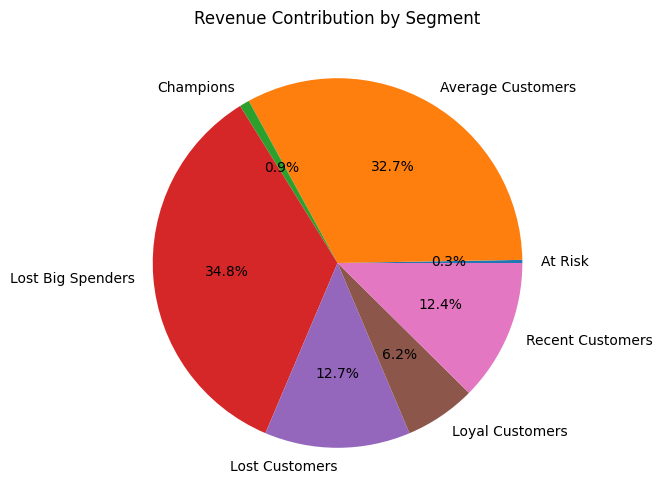

In [19]:
# Value contribution by segment
segment_value = rfm.groupby('Customer_Segment')['Monetary_Sum'].sum()
plt.figure(figsize=(10, 6))
plt.pie(segment_value, labels=segment_value.index, autopct='%1.1f%%')
plt.title('Revenue Contribution by Segment')
plt.show()


In [20]:
# STEP 5: Marketing Strategies


marketing_strategies = {
    'Champions': {
        'Strategy': 'Retention and Reward',
        'Actions': [
            'VIP membership program',
            'Early access to new products',
            'Exclusive events and experiences',
            'Personal shopping assistance'
        ],
        'Communication': 'Personalized, premium communication',
        'Frequency': 'Regular but not overwhelming'
    },
    'Loyal Customers': {
        'Strategy': 'Nurture and Upgrade',
        'Actions': [
            'Loyalty rewards program',
            'Cross-selling campaigns',
            'Premium product recommendations',
            'Birthday/anniversary specials'
        ],
        'Communication': 'Regular engagement',
        'Frequency': 'Bi-weekly'
    },
    'Recent Customers': {
        'Strategy': 'Engage and Convert',
        'Actions': [
            'Welcome series emails',
            'First-time buyer promotions',
            'Product education content',
            'Feedback surveys'
        ],
        'Communication': 'Educational and welcoming',
        'Frequency': 'Weekly initially'
    },
    'At Risk': {
        'Strategy': 'Reactivation',
        'Actions': [
            'Win-back campaigns',
            'Special discounts',
            'Product updates',
            'Satisfaction surveys'
        ],
        'Communication': 'Re-engagement focused',
        'Frequency': 'Targeted campaigns'
    }
}

In [21]:
# Print detailed marketing strategies
for segment, strategy in marketing_strategies.items():
    print(f"\n{segment}:")
    for key, value in strategy.items():
        print(f"{key}:")
        if isinstance(value, list):
            for item in value:
                print(f"  - {item}")
        else:
            print(f"  {value}")


Champions:
Strategy:
  Retention and Reward
Actions:
  - VIP membership program
  - Early access to new products
  - Exclusive events and experiences
  - Personal shopping assistance
Communication:
  Personalized, premium communication
Frequency:
  Regular but not overwhelming

Loyal Customers:
Strategy:
  Nurture and Upgrade
Actions:
  - Loyalty rewards program
  - Cross-selling campaigns
  - Premium product recommendations
  - Birthday/anniversary specials
Communication:
  Regular engagement
Frequency:
  Bi-weekly

Recent Customers:
Strategy:
  Engage and Convert
Actions:
  - Welcome series emails
  - First-time buyer promotions
  - Product education content
  - Feedback surveys
Communication:
  Educational and welcoming
Frequency:
  Weekly initially

At Risk:
Strategy:
  Reactivation
Actions:
  - Win-back campaigns
  - Special discounts
  - Product updates
  - Satisfaction surveys
Communication:
  Re-engagement focused
Frequency:
  Targeted campaigns


In [22]:
# Save results
rfm.to_csv('detailed_rfm_analysis.csv')
print("\nAnalysis results saved to 'detailed_rfm_analysis.csv'")


Analysis results saved to 'detailed_rfm_analysis.csv'
